In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.

recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Earliest: {recent[0]}")

Earliest: 2017-08-23


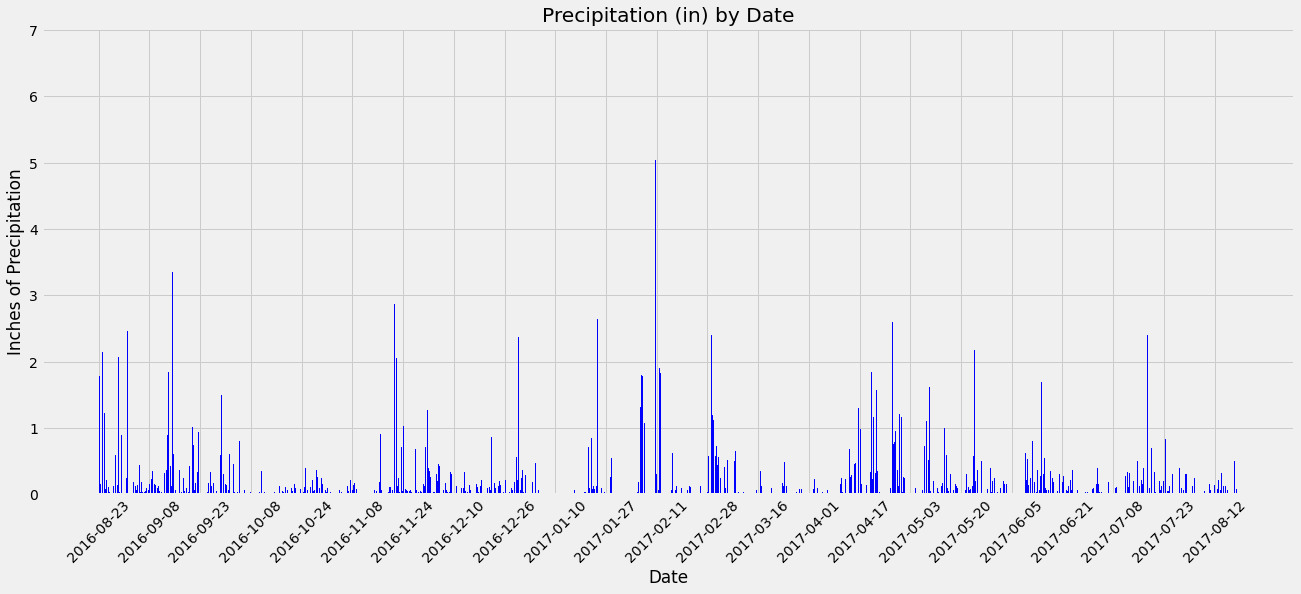

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recentdate = dt.datetime.strptime(recent[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
querydate = dt.date(recentdate.year -1, recentdate.month, recentdate.day)
querydate

# Perform a query to retrieve the data and precipitation scores

sel = [Measurement.date,Measurement.prcp]
queryresult = session.query(*sel).filter(Measurement.date >= querydate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcpdf = pd.DataFrame(queryresult, columns=['Date','Precipitation'])

# Sort the dataframe by date
prcpdf = prcpdf.sort_values(["Date"], ascending=True)
#prcpdf.head() - Noticed N/A values need to be dropped to plot
prcpdf = prcpdf.dropna(how="any")
#index reset needed to plot
prcpdf =prcpdf.set_index("Date")
prcpdf.head()
# Use Pandas Plotting with Matplotlib to plot the data
x_axis=np.arange(len(prcpdf))
y_axis=prcpdf["Precipitation"]

x_axis_list=list(prcpdf.index.values)
plt.figure(figsize=(20,8))
plt.bar(x_axis, y_axis, color=["blue"], alpha=1, align="center")


tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, x_axis_list, rotation=45)
plt.xticks(np.arange(0, len(x_axis)+1, 90))

plt.title("Precipitation (in) by Date")
plt.xlabel("Date")
plt.ylabel("Inches of Precipitation")
plt.show()



In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpdf.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station,func.count(Measurement.id)]
active = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
activestats = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
activestats


(54.0, 85.0, 71.66378066378067)

Text(0.5, 1.0, 'WAIHEE 837.5, HI US Temperatures: 2016-08-23 to 2017-08-23')

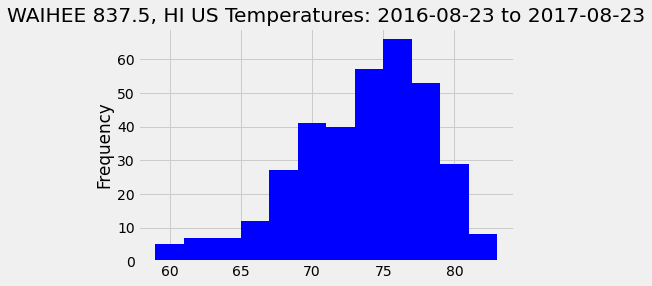

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
queryresult = session.query(Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date >= querydate).all()
temp = list(np.ravel(queryresult))

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
queryresult = session.query(*sel).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])

station = stations_desc.loc[stations_desc["Station"] == "USC00519281","Name"].tolist()[0]

plt.hist(temp, bins=12,rwidth=1.0,label='temps',color="blue")
plt.ylabel('Frequency')
plt.title(f"{station} Temperatures: {querydate} to {recent[0]}")

# Close session

In [16]:
# Close Session
session.close()